In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [20]:
PATH = os.path.join('.', 'data_dl')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

BATCH_SIZE = 32
image_size = 224
IMG_SIZE = (image_size, image_size)


train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1098 files belonging to 2 classes.


In [21]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 138 files belonging to 2 classes.


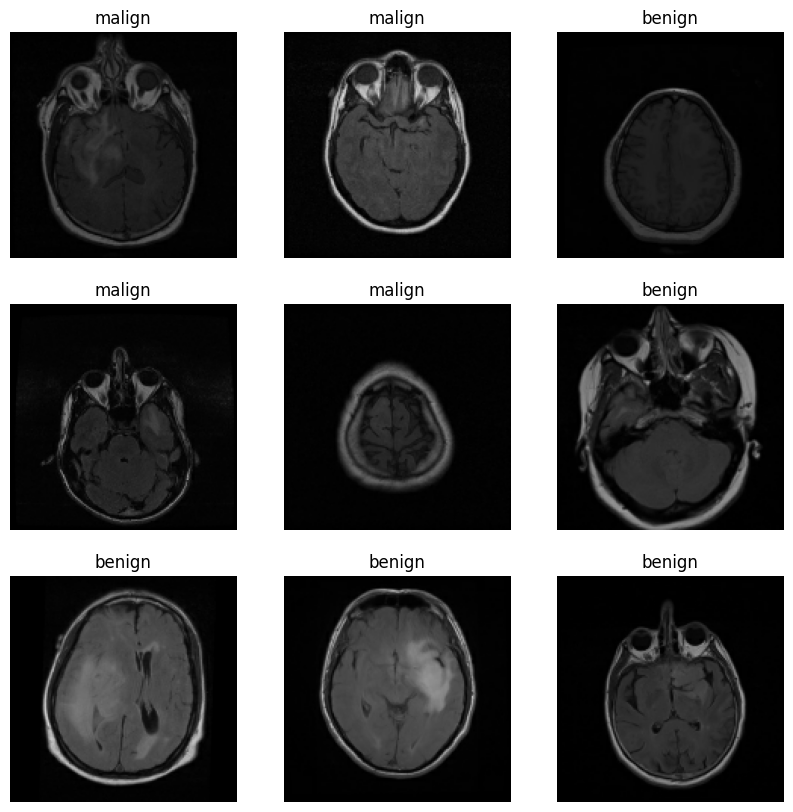

In [22]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [23]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [24]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 4
Number of test batches: 1


In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Augmentacja danych

In [26]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

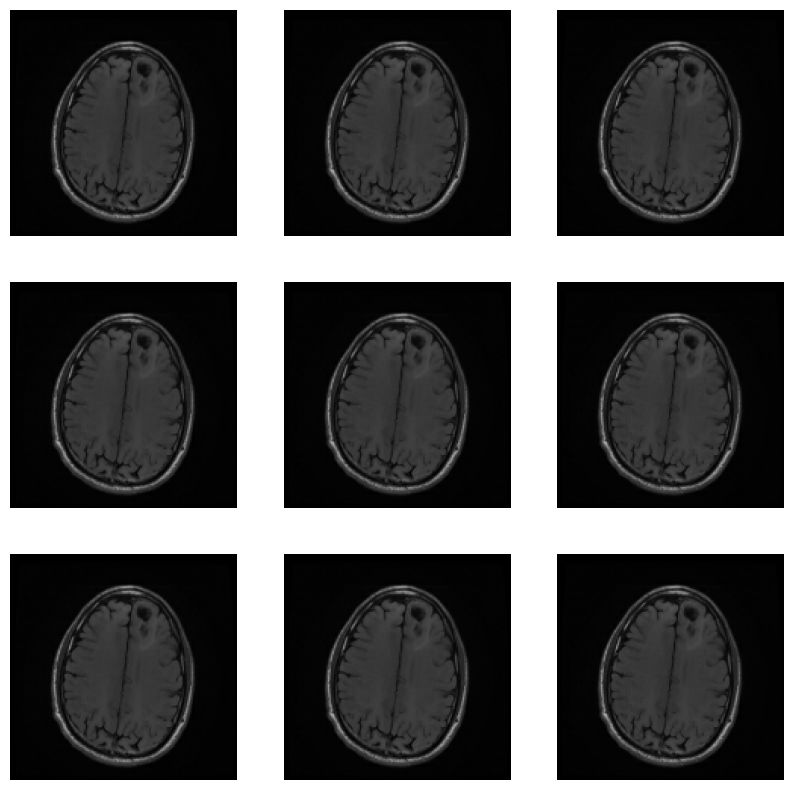

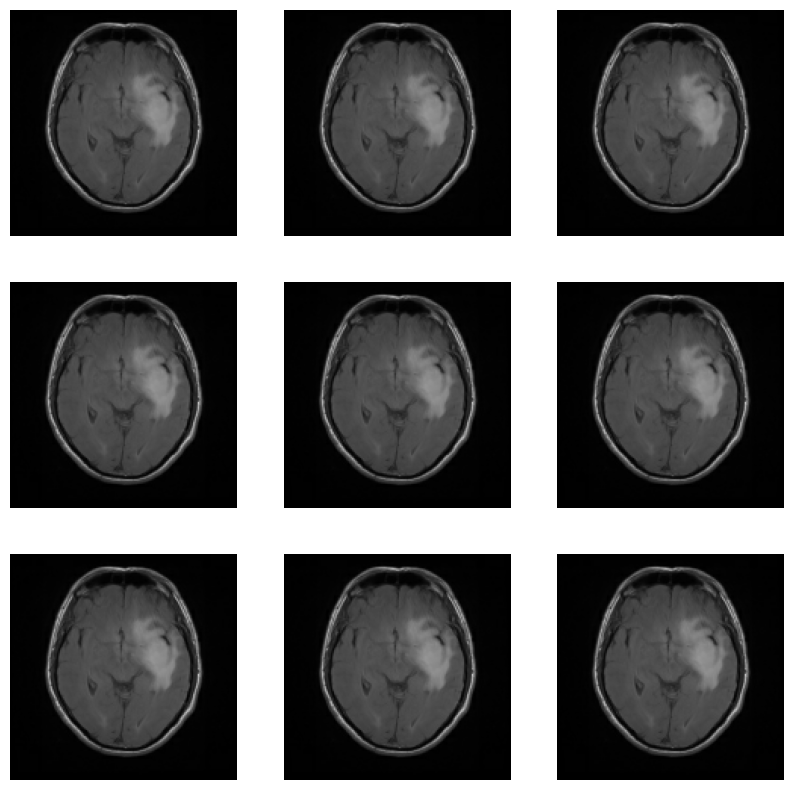

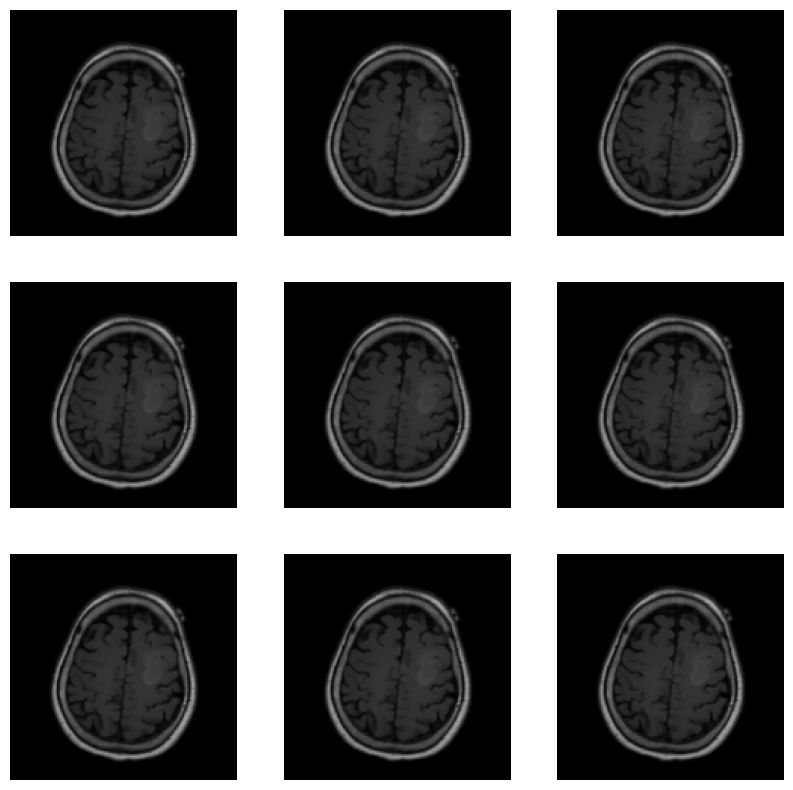

In [27]:
for image, _ in train_dataset.take(3):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Uczenie sieci

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [29]:
effnet = EfficientNetB0(weights='imagenet',include_top=True,input_shape=(image_size,image_size,3))

ValueError: When setting `include_top=True` and loading `imagenet` weights, `input_shape` should be (224, 224, 3).  Received: input_shape=(150, 150, 3)

In [ ]:
# model = effnet.output
# model = tf.keras.layers.GlobalAveragePooling2D()(model)
# model = tf.keras.layers.Dropout(rate=0.5)(model)
# model = tf.keras.layers.Dense(1,activation='softmax')(model)
# model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 150, 150, 3)  0           ['normalization[0][0]']      

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics=['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("startowa funkcja straty: {:.2f}".format(loss0))
print("Początkowa dokładność: {:.2f}".format(accuracy0))

4/4 [==============================] - 7s 556ms/step - loss: 0.0000e+00 - accuracy: 0.2453
startowa funkcja straty: 0.00
Początkowa dokładność: 0.25


In [ ]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=12, verbose=1, batch_size=BATCH_SIZE,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
35/35 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.2942
Epoch 1: val_accuracy improved from -inf to 0.25472, saving model to effnet.h5
35/35 [==============================] - 118s 3s/step - loss: 0.0000e+00 - accuracy: 0.2942 - val_loss: 0.0000e+00 - val_accuracy: 0.2547 - lr: 0.0010
Epoch 2/12
35/35 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.2942
Epoch 2: val_accuracy improved from 0.25472 to 0.28302, saving model to effnet.h5
35/35 [==============================] - 100s 3s/step - loss: 0.0000e+00 - accuracy: 0.2942 - val_loss: 0.0000e+00 - val_accuracy: 0.2830 - lr: 0.0010
Epoch 3/12
35/35 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.2942
Epoch 3: val_accuracy did not improve from 0.28302
35/35 [==============================] - 97s 3s/step - loss: 0.0000e+00 - accuracy: 0.2942 - val_loss: 0.0000e+00 - val_accuracy: 0.2642 - lr: 0.0010
Epoch 4/12
35/35 [========================

KeyboardInterrupt: 